### Extract Image Texture for Textural Analysis

Set up libraries and filepath for satellite image to perform spectral and textural analysis

In [28]:
# import libraries
# notebook run from myenv environment
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
from rasterio.warp import reproject, Resampling
from rasterio.plot import show
import os
import earthpy.plot as ep

from osgeo import gdal

In [29]:
# set the filepath and the filename (tif) as well as
filepath = 'C:/Data/atulip/ws/subset_area/site0/'
fn = 'pss_upolu_0623.tif'

In [6]:
# warp dataset to reproject to 4326
# gdal.Warp(os.path.join(filepath + 's2_23_rpj.tif'), os.path.join(filepath+fn),dstSRS='EPSG:4326')

#### Split multiband raster and export
Open multiband raster image. 
NB: NICFI data includes mask band (5 bands)

In [3]:
# replace fn with new reprojected layer
# fn = 's2_23_rpj.tif'
titles = ['Blue', 'Green', 'Red', 'NIR']

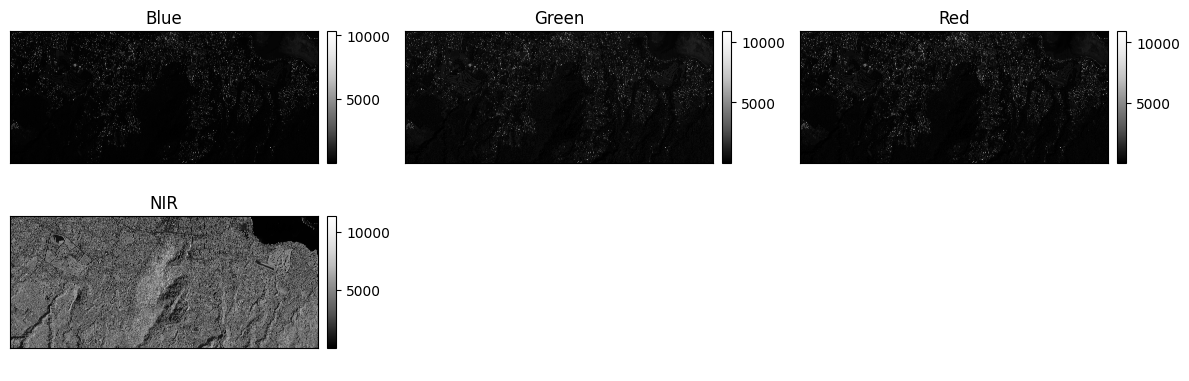

In [15]:
# open resampled image, load bands and plot each band separately
# NB: NICFI dataset has mask layer
with rio.open(os.path.join(filepath +  fn)) as src:
    img_array = src.read()
    b,g,r,n = src.read()
    meta = src.profile
    ep.plot_bands(src.read(),
                  title=titles,
                  figsize=(12, 4))

In [16]:
ls = [b,g,r,n]
ls_names = ['blue.tif', 'green.tif', 'red.tif', 'nir.tif']
# set output file path for all output that will be used for the model
output_path = 'C:/Data/atulip/ws/subset_area/site0/spectral/feat_dataset/'

In [17]:
# get shape
print('shape:', img_array.shape)
# read meta
print('metadata of image:', meta)
print('green', g)

shape: (4, 9423, 22127)
metadata of image: {'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 22127, 'height': 9423, 'count': 4, 'crs': CRS.from_epsg(32702), 'transform': Affine(0.5, 0.0, 411011.0,
       0.0, -0.5, 8470582.5), 'blockysize': 1, 'tiled': False, 'interleave': 'pixel'}
green [[453 440 389 ... 136 105  93]
 [491 485 447 ... 130 111 105]
 [516 504 466 ... 117 111 124]
 ...
 [277 303 334 ...  95 113 175]
 [303 354 424 ...  95 144 225]
 [328 392 493 ... 113 156 251]]


In [18]:
b = b*0.0001
g = g*0.0001
r = r*0.0001
n = n*0.0001

In [24]:
meta.update(count=1, compress='lzw', dtype = 'float32') # update metadata to have one count and float

In [25]:
for i in range(len(ls)):
    with rio.open(os.path.join(output_path + str(ls_names[i])), 'w', **meta) as dst:
        dst.write(ls[i],1)
        dst.close

### Indices

Calculate spectral indices for satellite image, unless retrieved from GEE.

In [21]:
import earthpy.spatial as es

### Spectral Indice Function

Build simple function to take raster file, separate bands, and put into four indices:
1. Red Green Index
2. GNDVI
3. NDVI
4. EBI

In [26]:
# create spectral index function
def indices(fn):
    # open file using rasterio (easier to write)
    with rio.open(os.path.join(filepath + fn), 'r') as src:
        meta = src.meta
        ras = src.read()
        b,g,r,n = src.read()
    
    # allow division by zero - uint16 
    np.seterr(divide='ignore', invalid='ignore')
    # divide ps imagery values and then convert type to float
    band_nir = (np.array(n)*0.0001).astype(float)
    band_red = (np.array(r)*0.0001).astype(float)
    band_green = (np.array(g)*0.0001).astype(float)
    band_blue = (np.array(b)*0.0001).astype(float)
    # update metadata for index
    meta.update(dtype=rio.float32, count=1, compress='lzw')

    def redg_fun(band_red, band_green):
        # calculate coloration index
        print("------- Calculating indice for red green:", fn, "----------")
        RG = (band_red - band_green)/(band_red + band_green)
        
        # path for filename to write
        w_fn = os.path.join(output_path + "redgreen.tif")
        # write filename
        with rio.open(w_fn, 'w', **meta) as dst:
          RG[np.isnan(RG)] = dst.nodata
          dst.write(RG, 1)
        return RG
        
    def gndvi_fun(band_nir, band_green):
        # calculate coloration index
        print("------- Calculating indice for gndvi", fn, "----------")
        GNDVI = (band_nir - band_green)/(band_nir + band_green)
        # path for filename to write
        w_fn = os.path.join(output_path + "gndvi.tif")
        # write filename
        with rio.open(w_fn, 'w', **meta) as dst:
          GNDVI[np.isnan(GNDVI)] = dst.nodata
          dst.write(GNDVI, 1)
        return GNDVI

    def ndvi_fun(band_nir, band_red):
        # calculate ndvi index
        print("------- Calculating indice for ndvi", fn, "----------")
        NDVI = (band_nir - band_red)/(band_nir + band_red)
        # path for filename to write
        w_fn = os.path.join(output_path + "ndvi.tif")
        # write filename
        with rio.open(w_fn, 'w', **meta) as dst:
          NDVI[np.isnan(NDVI)] = dst.nodata
          dst.write(NDVI, 1)
        return NDVI

    def ebi_fun(band_red, band_green,band_blue):
        # calculate coloration index
        print("------- Calculating indice for ebi", fn, "----------")
        EBI = (band_red + band_blue + band_green)/ ((band_green / band_red)* (band_red - band_blue + 1))
        # path for filename to write
        w_fn = os.path.join(output_path + "ebi.tif")
        # write filename
        with rio.open(w_fn, 'w', **meta) as dst:
          EBI[np.isnan(EBI)] = dst.nodata
          dst.write(EBI, 1)
        return EBI
    # apply function and store 
    redgreen = redg_fun(band_red, band_green)
    gndvi = gndvi_fun(band_nir, band_green)
    ndvi = ndvi_fun(band_nir, band_red)
    ebi = ebi_fun(band_red, band_green, band_blue)
    

    print("------Completed indexes calculation for:", fn, "---------")
    return redgreen, gndvi, ndvi, ebi

In [31]:
# run spectral index function
rg, gndvi, ndvi, ebi = indices(fn)

------- Calculating indice for ebi pss_upolu_0623.tif ----------
------Completed indexes calculation for: pss_upolu_0623.tif ---------


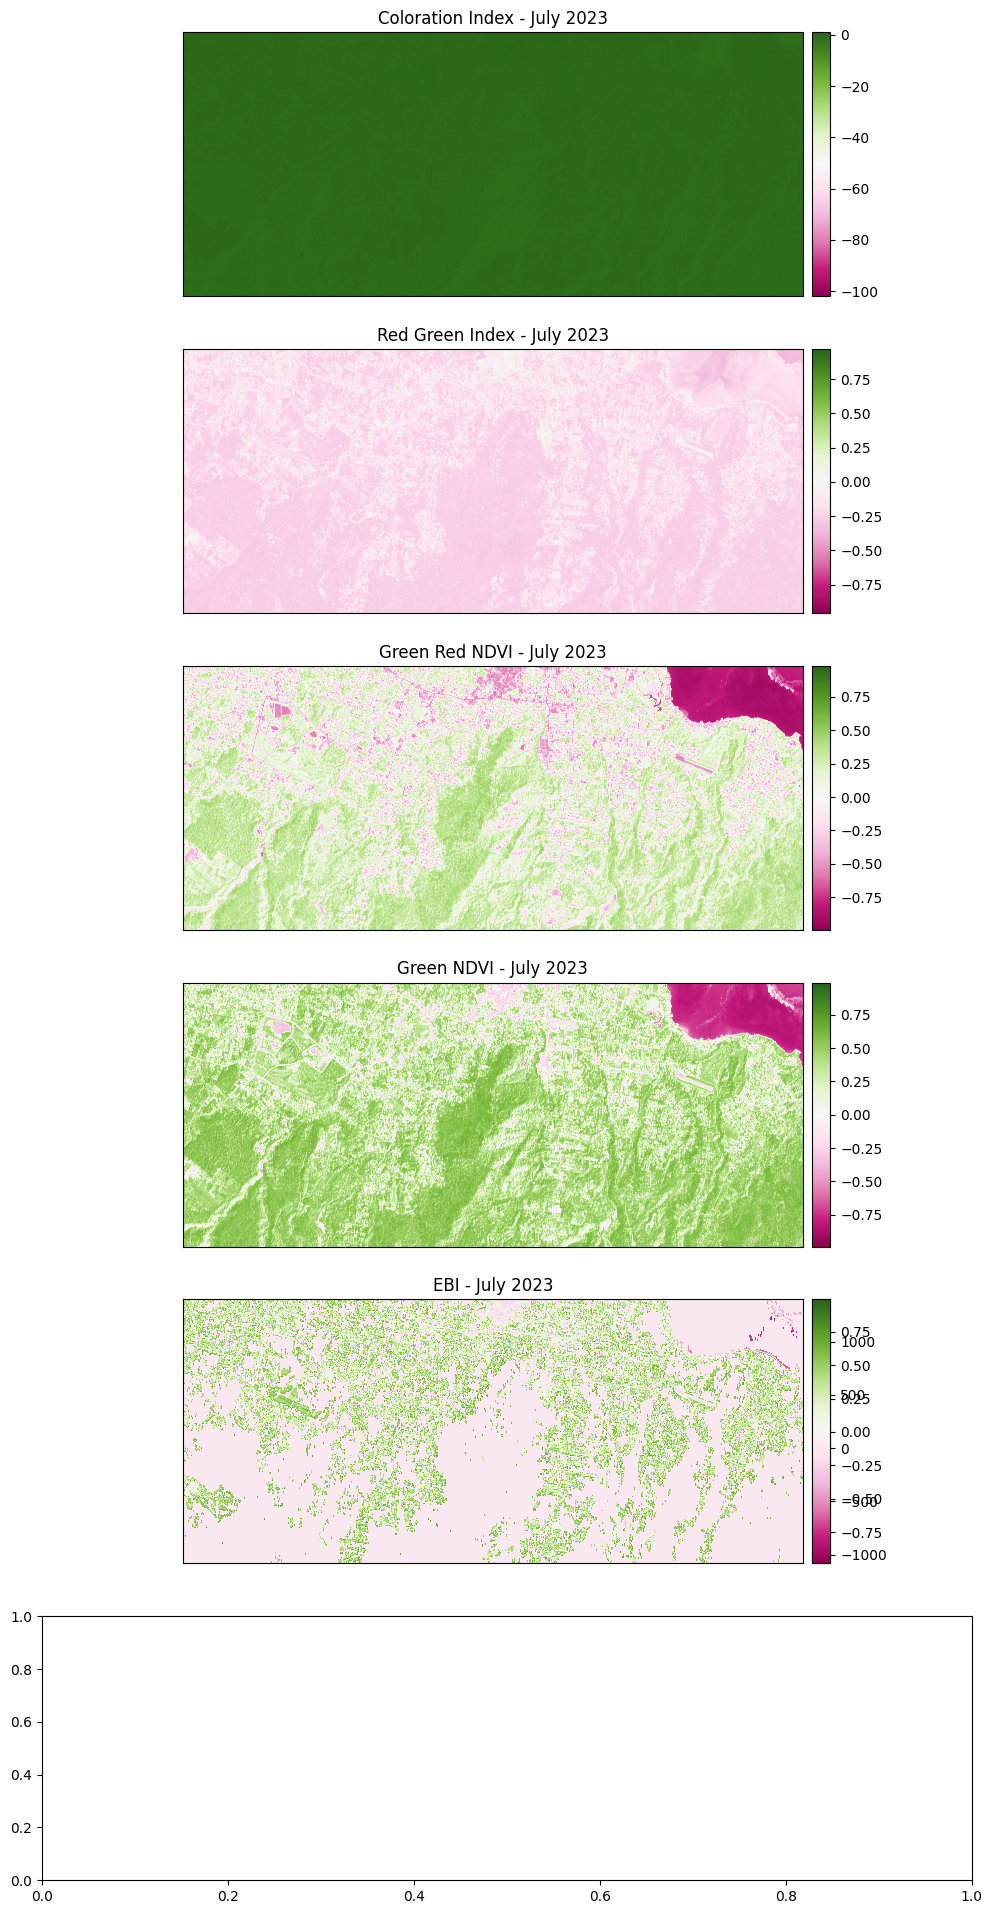

In [26]:
# create figure with two plots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 24))
ax1 = ep.plot_bands(rg,
              cmap='PiYG',
              scale=False,
              cbar = True,
              ax=ax2,
              title="Red Green Index - July 2023")
ax2 = ep.plot_bands(gndvi,
              cmap='PiYG',
              scale=False,
              cbar = True,
              ax=ax4,
              title="Green NDVI - July 2023")
ax3 = ep.plot_bands(ndvi,
              cmap='PiYG',
              scale=False,
              cbar = True,
              ax=ax5,
              title="NDVI - July 2023")
ax4 = ep.plot_bands(ebi,
              cmap='PiYG',
              scale=False,
              cbar = True,
              ax=ax5,
              title="EBI - July 2023")

# save figure then plot
plt.savefig(output_path + 'indices.png', bbox_inches='tight')
plt.show()
plt.close(fig)

### Calculate image texture
Apply GLCM and laplacian filters to derive image texture from satellite image


#### GLCM 
The GLCM function takes a multiband image, spilts these bands into separate ararys and then processes the GLCM individually. The files are then saved.

In [4]:
from skimage import io, measure, filters, color
from skimage.feature import graycomatrix, graycoprops
from skimage.filters.rank import entropy
from skimage.transform import resize
from skimage.util import img_as_ubyte, view_as_windows

from scipy import ndimage

In [5]:
def GLCM_function(fn, window_size, lvl):
    # open image, load bands and plot each band separately
    with rio.open(os.path.join(filepath + fn)) as src:
        img_array = src.read()
        b,g,r,n = src.read()
        src_meta = src.profile
        
    def GLCM_feat(s_img, window_size, lvl):
        rows, cols = s_img.shape
        # set empty arrays to same size as original array (input image)
        Contrast = np.zeros([rows, cols], dtype=np.int8)
        Dissimilarity = np.zeros([rows, cols], dtype=np.int8)
        Correlation = np.zeros([rows, cols], dtype=np.int8)
        Homogeneity = np.zeros([rows, cols], dtype=np.int8)
        Energy = np.zeros([rows, cols], dtype=np.int8)
        ASM = np.zeros([rows, cols], dtype=np.int8)
        
        for i in range(rows - window_size+1):
            # print(i)
            for j in range(cols - window_size+1):
                window = s_img[i:i+window_size, j:j+window_size]
                # calculate GLCM 
                glcm = graycomatrix(window, distances = [1], angles = [0], levels = lvl,
                        symmetric = True, normed = True)
                
                # calculate contrast, dissimiliarity, homogeneity, asm, energy and correlation
                Contrast[i,j] = graycoprops(glcm, 'contrast')[0,0]
                Dissimilarity[i,j] = graycoprops(glcm, 'dissimilarity')[0,0]
                Correlation[i,j] = graycoprops(glcm, 'correlation')[0,0]
                Homogeneity[i,j] = graycoprops(glcm, 'homogeneity')[0,0]
                Energy[i,j] = graycoprops(glcm, 'energy')[0,0]
                ASM[i,j] = graycoprops(glcm, 'ASM')[0,0]
                
        return np.stack((Contrast, Dissimilarity, Correlation, Homogeneity, Energy, ASM))

    ras_b = img_as_ubyte(b) 
    print('rescale blue and check shape', ras_b.shape)
    ras_g = img_as_ubyte(g)
    print('rescale green')
    ras_r = img_as_ubyte(r)
    print('rescale red')
    ras_n = img_as_ubyte(n)
    print('rescale NIR')

    glcm_b = GLCM_feat(ras_b, window_size, lvl)
    print('completed blue GLCM')
    glcm_g = GLCM_feat(ras_g, window_size, lvl)
    print('completed green GLCM')
    glcm_r = GLCM_feat(ras_r, window_size, lvl)
    print('completed red GLCM')
    glcm_n = GLCM_feat(ras_n, window_size, lvl)
    print('completed NIR GLCM')
    # update metadata
    src_meta.update(count = str(glcm_b.shape[0]))
    print(src_meta)
    print('------- write file ---------')
    
    # write output for each band 
    with rio.open(os.path.join(output_path +'blue_GLCM.tif'), 'w', **src_meta) as dst:
        dst.write(glcm_b)
        dst.descriptions = tuple(['bContrast', 'bDissimilarity', 'bCorrelation', 'bHomogeneity', 'bEnergy', 'bASM'])
        dst.close
    with rio.open(os.path.join(output_path +'green_GLCM.tif'), 'w', **src_meta) as dst:
        dst.write(glcm_g)
        dst.descriptions = tuple(['gContrast', 'gDissimilarity', 'gCorrelation', 'gHomogeneity', 'gEnergy', 'gASM'])
        dst.close
    with rio.open(os.path.join(output_path +'red_GLCM.tif'), 'w', **src_meta) as dst:
        dst.write(glcm_r)
        dst.descriptions = tuple(['rContrast', 'rDissimilarity', 'rCorrelation', 'rHomogeneity', 'rEnergy', 'rASM'])
        dst.close
    with rio.open(os.path.join(output_path +'nir_GLCM.tif'), 'w', **src_meta) as dst:
        dst.write(glcm_n)
        dst.descriptions = tuple(['nContrast', 'nDissimilarity', 'nCorrelation', 'nHomogeneity', 'nEnergy', 'nASM'])
        dst.close
        
    return glcm_b, glcm_g, glcm_r, glcm_n

In [6]:
# run blue band glcm function
b_glcm, g_glcm, r_glcm, n_glcm = GLCM_function(fn, 5, 256)

rescale blue and check shape (9423, 22127)
rescale green
rescale red
rescale NIR


KeyboardInterrupt: 

In [ ]:
# use list to split multiband to single bands
measure = ['Contrast', 'Dissimilarity', 'Correlation', 'Homogeneity', 'Energy', 'ASM']
bands = ['b','g','r','n'] 
files = ['blue_GLCM.tif', 'green_GLCM.tif', 'red_GLCM.tif', 'nir_GLCM.tif']

In [ ]:
# read in multiband GLCM raster and separate and store in file using this loop
for file in files:
    fp = os.path.join(output_path,file)
    with rio.open(os.path.join(fp)) as dst:
        print(dst.count)
    
        for band in range(1, dst.count + 1):
            single_band = dst.read(band)
        
            # set output name
            i = band -1
            metric = (file[:-8] + measure[i])
            outpath = os.path.join(output_path + metric + '.tif')
            print('output path: ' + outpath)
    
            # update metadata count
            meta = dst.meta
            meta.update(count = 1)
            
            #write individual band
            with rio.open(outpath, 'w', **meta) as dest:
                    dest.write(single_band, 1)
                    # dst.close

##### Entropy Function
Runs through each band (including NIR). Requires four bands and prints out four separate bands that are written into the file.

In [7]:
from scipy import ndimage
from scipy.stats import entropy

In [8]:
def entropy_function(fn, window_size):
# load in data and separate bands
        # open image, load bands and plot each band separately
    with rio.open(os.path.join(filepath + fn)) as src:
        img_array = src.read()
        b,g,r,n = src.read()
        src_meta = src.profile
        # scale raster
     
    ras_b = img_as_ubyte(b)
    print('rescale blue and check shape', ras_b.shape)
    ras_g = img_as_ubyte(g)
    print('rescale green')
    ras_r = img_as_ubyte(r)
    print('rescale red')
    ras_n = img_as_ubyte(n)
    print('rescale nir')
    
    def entropy_f(band, window_size):
        # check band data type
        print('data type:', band.dtype)
        Entropy = ndimage.generic_filter(band, entropy, size = window_size)

        return Entropy

    # run entropy function for each band - can use for loop but had issues executing
    b_ent = entropy_f(ras_b, window_size)
    print('completed blue entropy')
    g_ent = entropy_f(ras_g, window_size)
    print('completed green entropy')
    r_ent = entropy_f(ras_r, window_size)
    print('completed red entropy')
    n_ent = entropy_f(ras_n, window_size)
    print('completed nir entropy')

    
    # update metadata
    src_meta.update(count = 1)
    print('------- write file ---------')    

    # write for each band (separate)
    with rio.open(os.path.join(output_path + "b_entropy.tif"), 'w', **src_meta) as dst:
        dst.write(b_ent, 1)
        dst.close
    with rio.open(os.path.join(output_path + "g_entropy.tif"), 'w', **src_meta) as dst:
        dst.write(g_ent, 1)
        dst.close
    with rio.open(os.path.join(output_path + "r_entropy.tif"), 'w', **src_meta) as dst:
        dst.write(r_ent, 1)
        dst.close
    with rio.open(os.path.join(output_path + "n_entropy.tif"), 'w', **src_meta) as dst:
        dst.write(n_ent, 1)
        dst.close

    return b_ent, g_ent, r_ent, n_ent

In [ ]:
ent = entropy_function(fn, 5)

rescale blue and check shape (9423, 22127)
rescale green
rescale red
rescale nir
data type: uint8


##### Variance Filter

In [ ]:
def var_function(fn, window_size):
# load in data and separate bands
        # open image, load bands and plot each band separately
    with rio.open(os.path.join(filepath + fn)) as src:
        # img_array = src.read()
        b,g,r,n = src.read()
        src_meta = src.profile

    
    ras_b = img_as_ubyte(b) 
    print('rescale blue and check shape', ras_b.shape)
    ras_g = img_as_ubyte(g)
    print('rescale green')
    ras_r = img_as_ubyte(r)
    print('rescale red')
    ras_n = img_as_ubyte(n)
    print('rescale nir')

    def var_fun(band, window_size):
        # check band data type
        print('data type:', band.dtype)
        Variance = ndimage.generic_filter(band, np.var, size = window_size)

        return Variance
    
    # run variance function for each band - can use for loop but had issues executing
    b_var = var_fun(ras_b, window_size)
    print('completed blue var')
    g_var = var_fun(ras_g, window_size)
    print('completed green var')
    r_var = var_fun(ras_r, window_size)
    print('completed red var')
    n_var = var_fun(ras_n, window_size)
    print('completed nir var')

    
    # update metadata
    src_meta.update(count = 1)
    print('------- write file ---------')    

    # write for each band (separate)
    with rio.open(os.path.join(output_path + "b_var.tif"), 'w', **src_meta) as dst:
        dst.write(b_var,1)
        dst.close
    with rio.open(os.path.join(output_path + "g_var.tif"), 'w', **src_meta) as dst:
        dst.write(g_var,1)
        dst.close
    with rio.open(os.path.join(output_path + "r_var.tif"), 'w', **src_meta) as dst:
        dst.write(r_var,1)
        dst.close
    with rio.open(os.path.join(output_path + "n_var.tif"), 'w', **src_meta) as dst:
        dst.write(n_var,1)
        dst.close

    return b_var, g_var, r_var, n_var

In [ ]:
bv, gv, rb, nv = var_function(fn, 5)

#### Additional Filters
1. Laplacian Filter
2. Roughness (Maximum Filter)

##### Laplacian Filter

In [69]:
# create gdal slope function
def laplacian_ds(fn):
    # correct path for filename
    i_fn = os.path.join(filepath + fn)
    # path for filename to write
    w_fn = os.path.join(output_path + "laplacian.tif")
    print("------- loaded data :", fn, "----------")
    
    # open file using rasterio (easier to write)
    with rio.open(i_fn, 'r') as src:
        profile = src.profile
        src_meta = src.meta
        ras = src.read()

    # run laplacian filter
    out_lap = ndimage.laplace(ras, mode = 'reflect')
    print("------Completed Laplacian filter:", fn, "---------")
    
    with rio.open(w_fn, 'w', **src_meta) as dst:
        dst.write(out_lap)
        dst.close

    return out_lap

In [ ]:
# run laplacian filter
lap_dem = laplacian_ds(fn)

In [ ]:
fn_laplacian = os.path.join(output_path + "laplacian.tif")
measure = 'laplacian'

In [ ]:
# write bands as single using this loop
with rio.open(fn_laplacian) as dst:
    print(dst.count)
    
    for band in range(1, dst.count + 1):
        single_band = dst.read(band)
        i = band -1
        # set output name
        file = files[i]
        metric = (file[:-4] + measure)
        outpath = os.path.join(output_path + metric + '.tif')
        print('output path: ' + outpath)
    
        # update metadata count
        meta = dst.meta
        meta.update(count = 1)
            
        #write individual band
        with rio.open(outpath, 'w', **meta) as dest:
            dest.write(single_band, 1)

### Roughness raster grids
Apply filter that returns the maximum difference in values between a target pixel and it's eight neighbours (range). There are no direct tools available in scipy or skimage and so a difference grid between a maximum and minimum difference filter is performed, with a user-defined size (set to 3). Alternatively a range filter is available in whitebox tools.

In [73]:
# create gdal slope function
def roughness_ds(fn, size):
    # correct path for filename
    i_fn = os.path.join(filepath + fn)
    # path for filename to write
    w_fn = os.path.join(output_path + fn[:-4] + "_max_diff.tif")
    print("------- loaded data :", fn, "----------")
    
    # open file using rasterio (easier to write)
    with rio.open(i_fn, 'r') as src:
        profile = src.profile
        src_meta = src.meta
        ras = src.read()

    # run range filter (roughness filter) using whitebox
    out_max = ndimage.maximum_filter(ras, size)
    out_min = ndimage.minimum_filter(ras, size)
    out_range = out_max - out_min
    print("------Completed Min and Max filter for ", fn, "---------")
    
    with rio.open(w_fn, 'w', **src_meta) as dst:
        dst.write(out_range)
        dst.close

    print("------Export range raster for ", fn, "---------")
    return out_range

In [74]:
# run roughness filter
ro_dem = roughness_ds(fn, 3)

------- loaded data : site2.tif ----------
------Completed Min and Max filter for  site2.tif ---------
------Export range raster for  site2.tif ---------


In [75]:
fn_roughness = os.path.join(output_path + fn[:-4] + "_max_diff.tif")
measure = 'max_diff'
bands = ['b','g','r','n']

In [76]:
# write bands as single using this loop
with rio.open(fn_roughness) as dst:
    print(dst.count)
    
    for band in range(1, dst.count + 1):
        single_band = dst.read(band)
        i = band -1
        # set output name
        file = files[i]
        metric = (file[:-4] + measure)
        outpath = os.path.join(output_path + metric + '.tif')
        print('output path: ' + outpath)
    
        # update metadata count
        meta = dst.meta
        meta.update(count = 1)
            
        #write individual band
        with rio.open(outpath, 'w', **meta) as dest:
            dest.write(single_band, 1)

4
output path: C:/Data/atulip/ws/subset_area/site2/dataset/blue_rough.tif
output path: C:/Data/atulip/ws/subset_area/site2/dataset/green_rough.tif
output path: C:/Data/atulip/ws/subset_area/site2/dataset/red_rough.tif
output path: C:/Data/atulip/ws/subset_area/site2/dataset/NIR_rough.tif
